In [ ]:
!pip install -q kaggle


In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose your kaggle.json file when prompted

# Make a .kaggle directory and move the JSON there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Replace USERNAME/DATASET-SLUG with the actual slug from Kaggle
!kaggle datasets download -d mdwahid221155510/iot-dataset

# Unzip the dataset
!unzip -q iot-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/mdwahid221155510/iot-dataset
License(s): unknown
 99% 0.98G/0.99G [00:07<00:00, 228MB/s]
100% 0.99G/0.99G [00:07<00:00, 136MB/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4
Checking dataset structure at: /content/weeddata
✓ train folder found
  - Images: 3131
  - Labels: 3131
✓ valid folder found
  - Images: 300
  - Labels: 300
✓ test folder found
  - Images: 150
  - Labels: 150
✓ data.yaml found
Number of classes: 6
Class names: ['Clover', 'Crabgrass', 'Gamochaeta', 'Hand', 'Sphagneticola', 'Syndrella']
Loading YOLOv8 yolov8n model...
Using device: cuda
Model loaded successfully!
Model architecture: yolov8n
Results will be saved in: yolo_training_results
Starting training...
Training parameters: Epochs=100, Image Size=640, Batch Size=16
Ultralytics 8.3.221 🚀 Python-3.12.12 torch

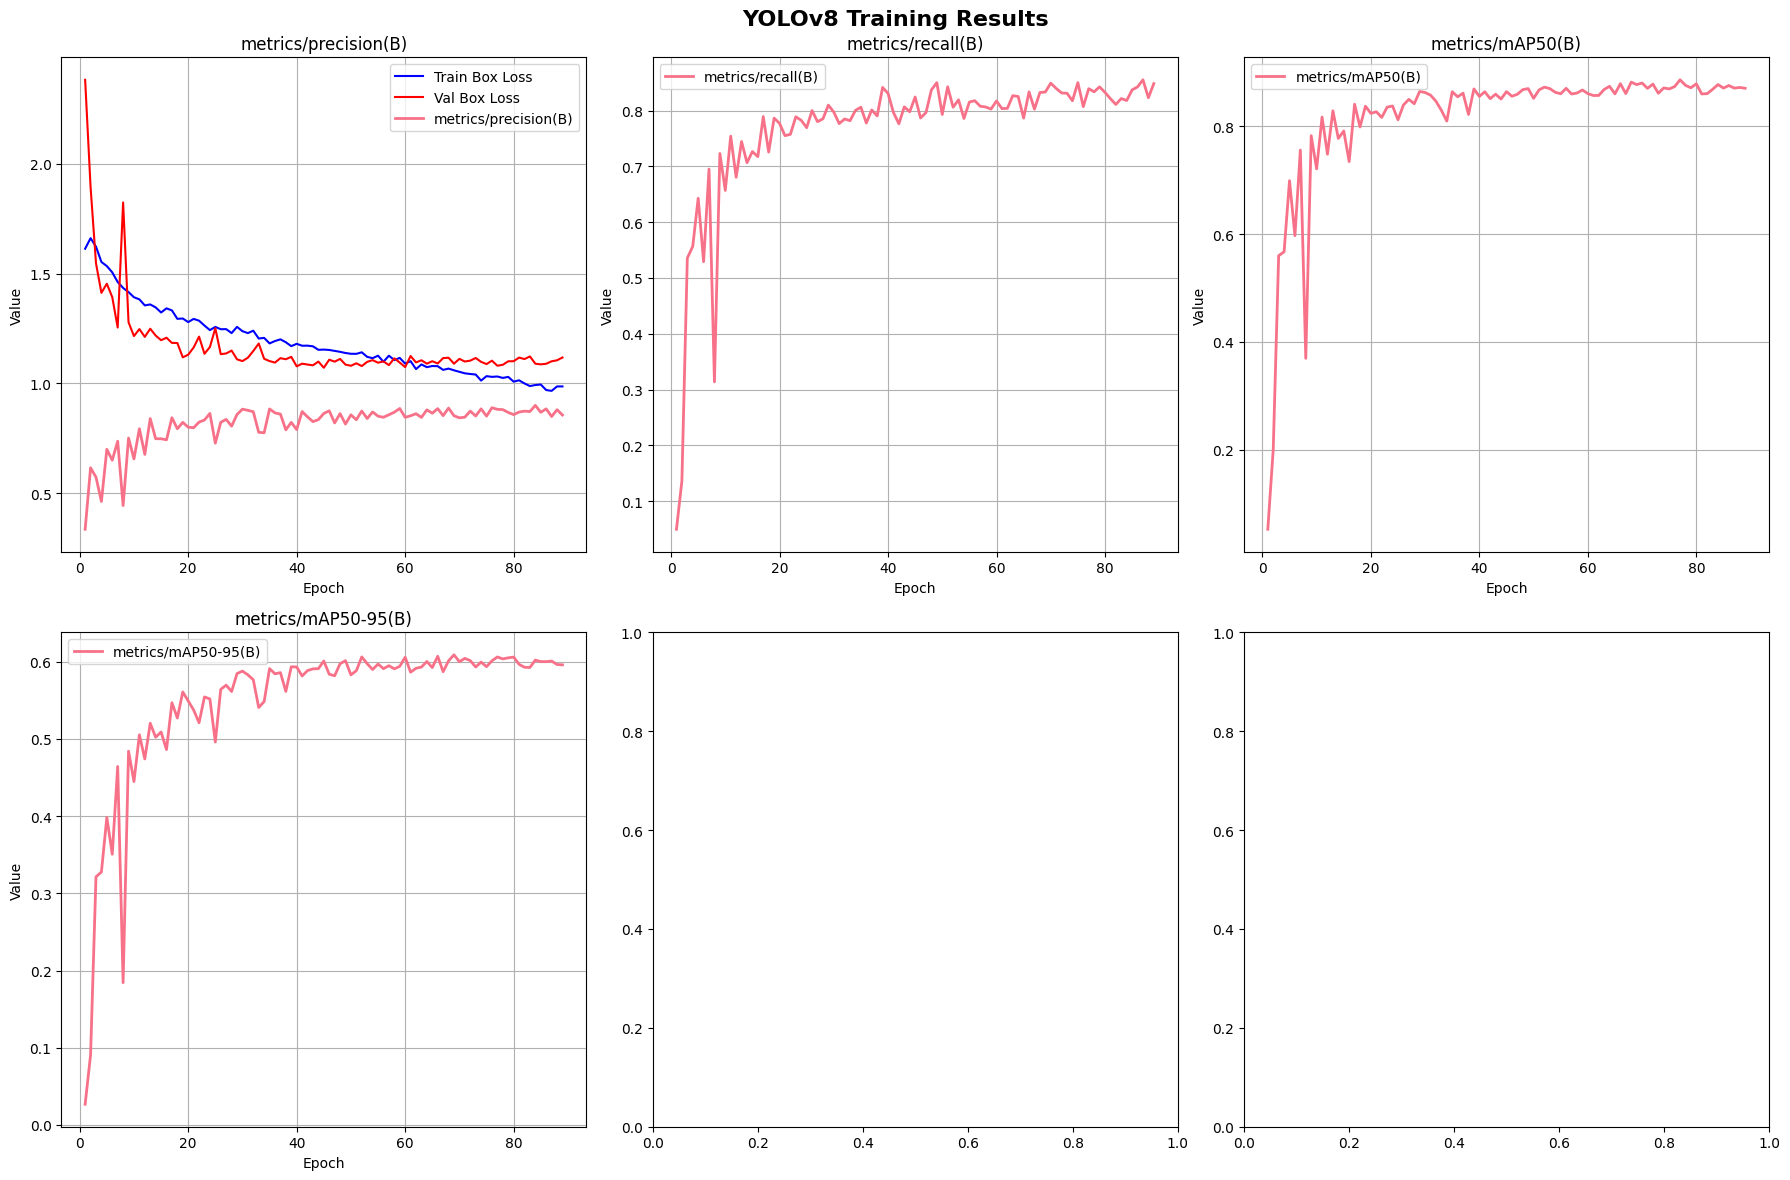


Confusion Matrix:


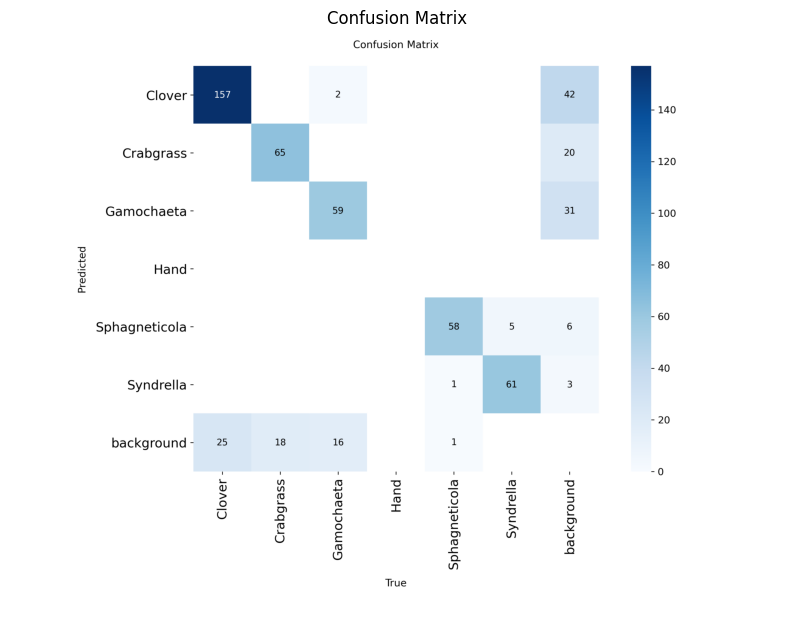

Testing model on test set...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 54.5±45.0 MB/s, size: 387.6 KB)
val: Scanning /content/weeddata/test/labels... 150 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 150/150 456.7it/s 0.3s
val: New cache created: /content/weeddata/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 2.4it/s 4.2s
                   all        150        251      0.899      0.835      0.896      0.644
                Clover         22         83      0.909      0.892      0.953       0.67
             Crabgrass         33         44      0.887      0.795      0.893       0.54
            Gamochaeta         38         67      0.833      0.552      0.691      0.458
         Sphagneticola         25         25       0.88          1      0.976      0.822
             Syndrella         32         32    

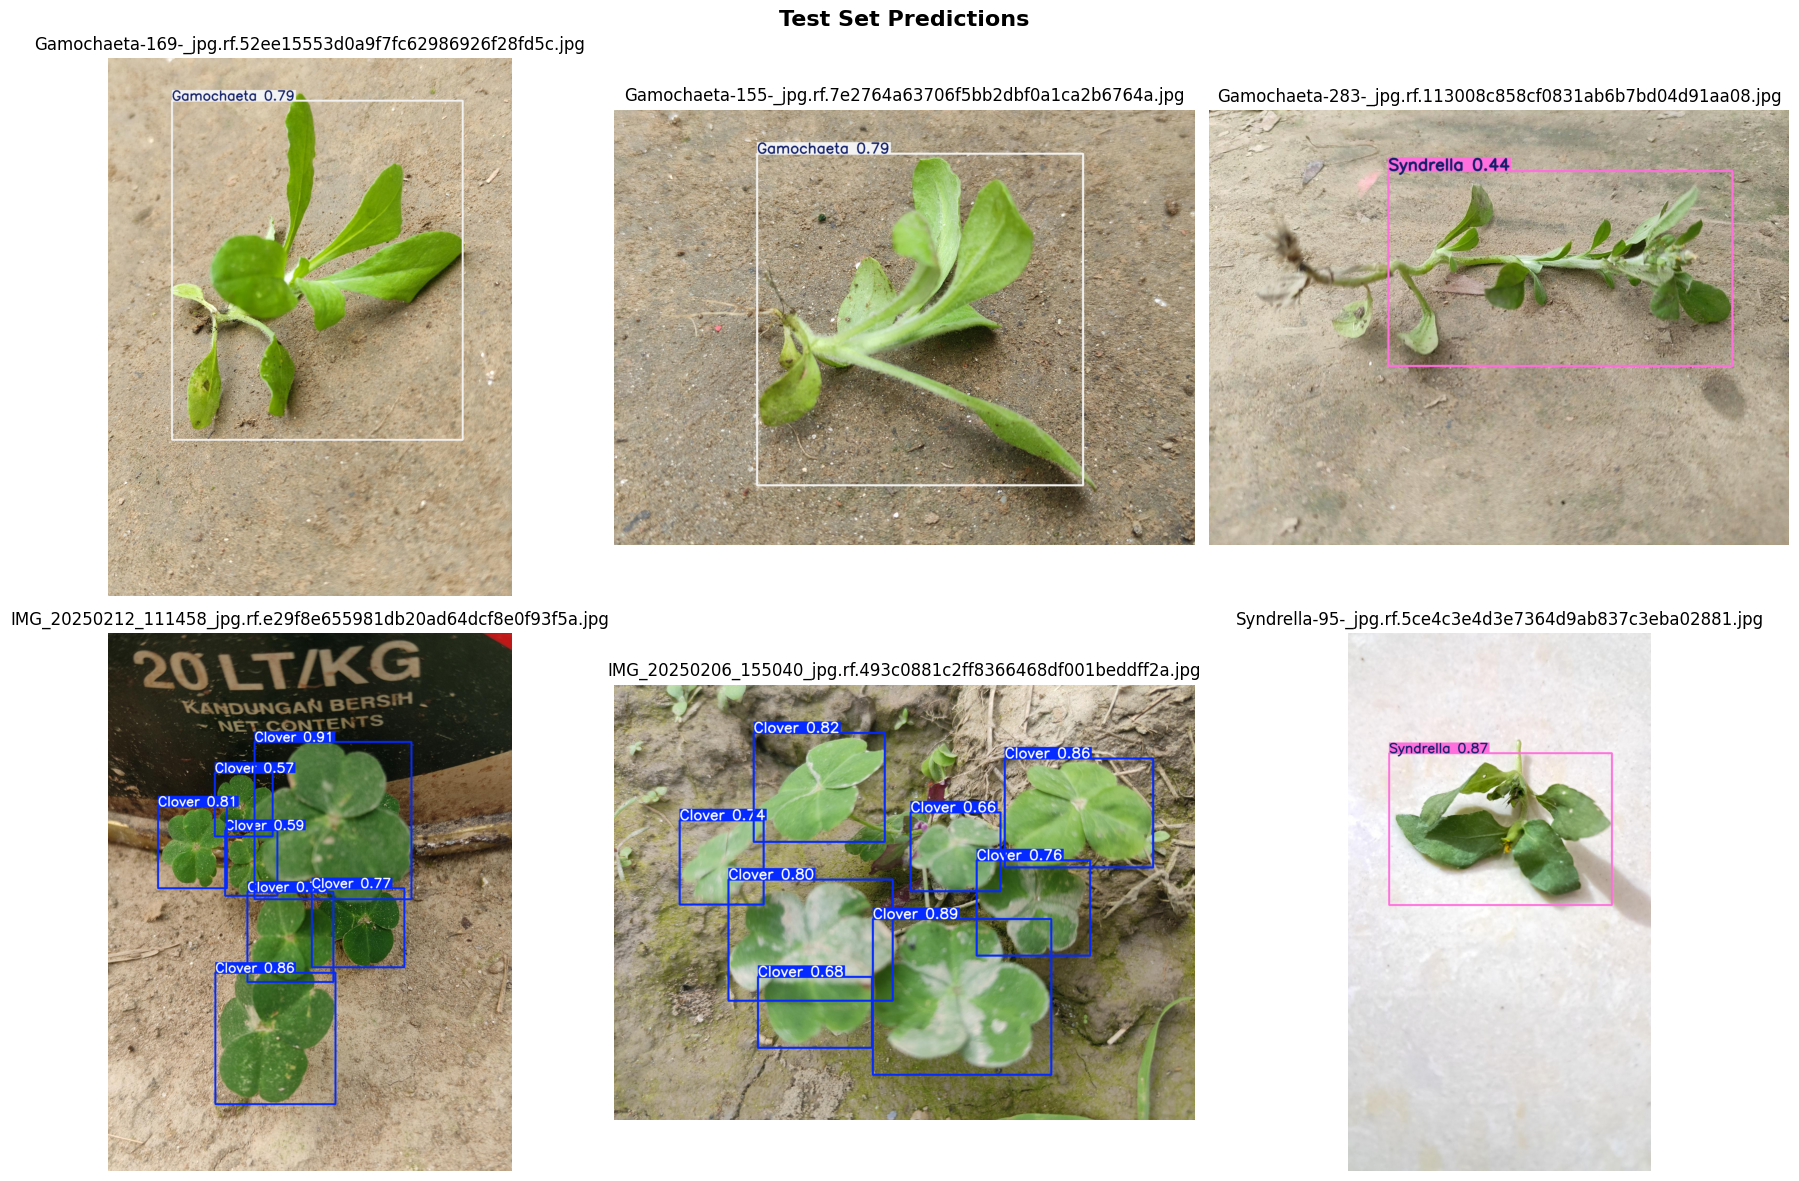

Saving and exporting model with ONNX quantization...


ModuleNotFoundError: No module named 'onnxruntime'

In [ ]:
# =============================================================================
# CELL 1: Install Dependencies
# =============================================================================
# !pip install ultralytics
# !pip install roboflow
# !pip install matplotlib seaborn
# !pip install opencv-python
# !pip install pillow

# =============================================================================
# CELL 2: Import Libraries
# =============================================================================
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import cv2
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU for training")

# =============================================================================
# CELL 3: Setup Paths and Validate Dataset
# =============================================================================
# UPDATE THIS PATH TO YOUR DATASET LOCATION
DATASET_PATH = r"/content/weeddata"  # ← CHANGE THIS TO YOUR ACTUAL DATASET PATH

def validate_dataset_structure(dataset_path):
    """Validate the dataset has the correct structure"""
    required_folders = ['train', 'valid', 'test']
    yaml_file = os.path.join(dataset_path, 'data.yaml')

    print(f"Checking dataset structure at: {dataset_path}")

    # Check if main folders exist
    for folder in required_folders:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.exists(folder_path):
            print(f"✓ {folder} folder found")
            # Check for images and labels subfolders
            images_path = os.path.join(folder_path, 'images')
            labels_path = os.path.join(folder_path, 'labels')

            if os.path.exists(images_path):
                img_count = len([f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                print(f"  - Images: {img_count}")
            else:
                print(f"  - ❌ Images folder not found in {folder}")

            if os.path.exists(labels_path):
                label_count = len([f for f in os.listdir(labels_path) if f.endswith('.txt')])
                print(f"  - Labels: {label_count}")
            else:
                print(f"  - ❌ Labels folder not found in {folder}")
        else:
            print(f"❌ {folder} folder not found")

    # Check for YAML file
    if os.path.exists(yaml_file):
        print(f"✓ data.yaml found")
        with open(yaml_file, 'r') as f:
            yaml_content = yaml.safe_load(f)
            print(f"Number of classes: {yaml_content.get('nc', 'Not specified')}")
            print(f"Class names: {yaml_content.get('names', 'Not specified')}")
    else:
        print(f"❌ data.yaml not found")

    return yaml_file if os.path.exists(yaml_file) else None

# Validate the dataset
yaml_path = validate_dataset_structure(DATASET_PATH)
if yaml_path is None:
    print("ERROR: Please check your dataset path and structure!")
    print("Make sure you have updated DATASET_PATH in the code above.")

# =============================================================================
# CELL 4: Load and Initialize Model
# =============================================================================
# You can choose different model sizes: yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
# n=nano (fastest), s=small, m=medium, l=large, x=extra large (most accurate)
MODEL_SIZE = 'yolov8n'  # Using nano for faster CPU training

print(f"Loading YOLOv8 {MODEL_SIZE} model...")
model = YOLO(f'{MODEL_SIZE}.pt')  # This will download the pre-trained model if not present

# Determine device to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Display model information
print(f"Model loaded successfully!")
print(f"Model architecture: {MODEL_SIZE}")

# Create output directory for results
output_dir = "yolo_training_results"
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved in: {output_dir}")

# =============================================================================
# CELL 5: Train the Model
# =============================================================================
print("Starting training...")

# Training parameters - automatically adjusted based on available hardware
if device == 'cpu':
    EPOCHS = 50  # Reduced epochs for CPU training
    IMG_SIZE = 416  # Smaller image size for faster CPU training
    BATCH_SIZE = 4  # Smaller batch size for CPU
    WORKERS = 2  # Fewer workers for CPU
    print("⚠️  CPU training detected - using optimized parameters for CPU")
else:
    EPOCHS = 100  # Full epochs for GPU training
    IMG_SIZE = 640  # Standard image size
    BATCH_SIZE = 16  # Standard batch size
    WORKERS = 4  # Standard workers for GPU

print(f"Training parameters: Epochs={EPOCHS}, Image Size={IMG_SIZE}, Batch Size={BATCH_SIZE}")

# Train the model
try:
    results = model.train(
        data=yaml_path,  # Path to your data.yaml file
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        name='yolo_custom_training',  # Name for the training run
        project=output_dir,  # Project directory
        patience=20,  # Early stopping patience
        save=True,  # Save checkpoints
        cache=False,  # Cache images for faster training (set to True if you have enough RAM)
        device=device,  # Use detected device (CPU or CUDA)
        workers=WORKERS,  # Number of dataloader workers
        optimizer='AdamW',  # Optimizer choice
        lr0=0.01,  # Initial learning rate
        momentum=0.937,  # Momentum
        weight_decay=0.0005,  # Weight decay
        cls=0.5,  # Class loss weight
        box=7.5,  # Box loss weight
        dfl=1.5,  # DFL loss weight
    )

    print("Training completed successfully!")
    print(f"Results saved in: {results.save_dir}")

except Exception as e:
    print(f"Training failed with error: {e}")
    print("Please check your dataset path and YAML file.")

# =============================================================================
# CELL 6: Evaluate Model Performance
# =============================================================================
print("Evaluating model performance...")

# Load the best trained model
best_model_path = os.path.join(output_dir, 'yolo_custom_training', 'weights', 'best.pt')

if os.path.exists(best_model_path):
    trained_model = YOLO(best_model_path)

    # Run validation
    try:
        val_results = trained_model.val(
            data=yaml_path,
            imgsz=IMG_SIZE,
            batch=BATCH_SIZE,
            conf=0.25,  # Confidence threshold
            iou=0.5,   # IoU threshold for NMS
            device=device
        )

        # Print validation metrics
        print("\n=== Validation Results ===")
        print(f"mAP50: {val_results.box.map50:.4f}")
        print(f"mAP50-95: {val_results.box.map:.4f}")
        print(f"Precision: {val_results.box.mp:.4f}")
        print(f"Recall: {val_results.box.mr:.4f}")

        # Create a summary of metrics
        metrics_summary = {
            'mAP50': val_results.box.map50,
            'mAP50-95': val_results.box.map,
            'Precision': val_results.box.mp,
            'Recall': val_results.box.mr,
            'F1-Score': 2 * (val_results.box.mp * val_results.box.mr) / (val_results.box.mp + val_results.box.mr)
        }

        # Display metrics in a nice format
        metrics_df = pd.DataFrame([metrics_summary])
        print("\n=== Metrics Summary ===")
        print(metrics_df.round(4))

    except Exception as e:
        print(f"Validation failed: {e}")

else:
    print("Best model not found. Please check if training completed successfully.")

# =============================================================================
# CELL 7: Visualize Training Results
# =============================================================================
print("Creating training visualizations...")

# Path to training results
results_path = os.path.join(output_dir, 'yolo_custom_training')

# Read training results CSV if available
results_csv_path = os.path.join(results_path, 'results.csv')

if os.path.exists(results_csv_path):
    try:
        df = pd.read_csv(results_csv_path)
        df.columns = df.columns.str.strip()  # Remove any whitespace from column names

        # Create subplots for different metrics
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('YOLOv8 Training Results', fontsize=16, fontweight='bold')

        # Loss plots
        loss_cols = [col for col in df.columns if 'loss' in col.lower()]
        if len(loss_cols) >= 2:
            train_box_loss = [col for col in loss_cols if 'train' in col and 'box' in col]
            val_box_loss = [col for col in loss_cols if 'val' in col and 'box' in col]

            if train_box_loss and val_box_loss:
                axes[0, 0].plot(df['epoch'], df[train_box_loss[0]], label='Train Box Loss', color='blue')
                axes[0, 0].plot(df['epoch'], df[val_box_loss[0]], label='Val Box Loss', color='red')
                axes[0, 0].set_title('Box Loss')
                axes[0, 0].set_xlabel('Epoch')
                axes[0, 0].set_ylabel('Loss')
                axes[0, 0].legend()
                axes[0, 0].grid(True)

        # Additional plots for other metrics
        metric_cols = [col for col in df.columns if 'map' in col.lower() or 'precision' in col.lower() or 'recall' in col.lower()]

        if metric_cols:
            for i, col in enumerate(metric_cols[:5]):  # Plot first 5 metric columns
                row = i // 3
                col_idx = i % 3
                if row < 2 and col_idx < 3:
                    axes[row, col_idx].plot(df['epoch'], df[col], label=col, linewidth=2)
                    axes[row, col_idx].set_title(col)
                    axes[row, col_idx].set_xlabel('Epoch')
                    axes[row, col_idx].set_ylabel('Value')
                    axes[row, col_idx].legend()
                    axes[row, col_idx].grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'training_results.png'), dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"Error creating training visualizations: {e}")

else:
    print("Results CSV not found. Training might have failed or be incomplete.")

# Display confusion matrix if available
confusion_matrix_path = os.path.join(results_path, 'confusion_matrix.png')
if os.path.exists(confusion_matrix_path):
    try:
        print("\nConfusion Matrix:")
        cm_img = plt.imread(confusion_matrix_path)
        plt.figure(figsize=(10, 8))
        plt.imshow(cm_img)
        plt.axis('off')
        plt.title('Confusion Matrix')
        plt.show()
    except Exception as e:
        print(f"Error displaying confusion matrix: {e}")

# =============================================================================
# CELL 8: Test Model on Test Set
# =============================================================================
print("Testing model on test set...")

if os.path.exists(best_model_path):
    try:
        # Test the model
        test_results = trained_model.val(
            data=yaml_path,
            split='test',  # Use test split
            imgsz=IMG_SIZE,
            batch=BATCH_SIZE,
            conf=0.25,
            iou=0.5,
            device=device
        )

        print("\n=== Test Set Results ===")
        print(f"Test mAP50: {test_results.box.map50:.4f}")
        print(f"Test mAP50-95: {test_results.box.map:.4f}")
        print(f"Test Precision: {test_results.box.mp:.4f}")
        print(f"Test Recall: {test_results.box.mr:.4f}")

        # Run predictions on some test images
        test_images_path = os.path.join(DATASET_PATH, 'test', 'images')
        if os.path.exists(test_images_path):
            test_images = [f for f in os.listdir(test_images_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:6]  # Take first 6 images

            if test_images:
                print(f"\nRunning predictions on {len(test_images)} test images...")

                # Create subplot for predictions
                fig, axes = plt.subplots(2, 3, figsize=(18, 12))
                fig.suptitle('Test Set Predictions', fontsize=16, fontweight='bold')

                for i, img_name in enumerate(test_images):
                    if i >= 6:  # Only show first 6 images
                        break

                    img_path = os.path.join(test_images_path, img_name)

                    try:
                        # Run prediction
                        results_pred = trained_model.predict(
                            source=img_path,
                            conf=0.25,
                            iou=0.5,
                            save=False,
                            verbose=False
                        )

                        # Plot the result
                        row = i // 3
                        col = i % 3

                        # Get the annotated image
                        annotated_img = results_pred[0].plot()
                        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

                        axes[row, col].imshow(annotated_img)
                        axes[row, col].set_title(f'{img_name}')
                        axes[row, col].axis('off')

                    except Exception as e:
                        print(f"Error processing {img_name}: {e}")

                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, 'test_predictions.png'), dpi=300, bbox_inches='tight')
                plt.show()
            else:
                print("No test images found.")
        else:
            print("Test images directory not found.")

    except Exception as e:
        print(f"Testing failed: {e}")
# =============================================================================
# CELL 9 (UPDATED): Save, Export, and Quantize Model
# =============================================================================
print("Saving and exporting model with ONNX quantization...")

from onnxruntime.quantization import quantize_dynamic, QuantType

if os.path.exists(best_model_path):
    try:
        # Directory to save exported models
        export_dir = os.path.join(output_dir, "exported_models")
        os.makedirs(export_dir, exist_ok=True)

        # ---------------------------------------------------------------------
        # Step 1. Export to ONNX
        # ---------------------------------------------------------------------
        print("🔄 Exporting YOLOv8 model to ONNX...")
        onnx_export_path = trained_model.export(
            format="onnx",  # ONNX export
            dynamic=True,   # dynamic axes for flexible input sizes
            simplify=True   # simplify model graph
        )
        print(f"✅ ONNX model exported: {onnx_export_path}")

        # ---------------------------------------------------------------------
        # Step 2. Quantize ONNX for lightweight deployment
        # ---------------------------------------------------------------------
        print("⚙️ Performing dynamic quantization on ONNX model...")
        quantized_onnx_path = os.path.join(export_dir, "model_quantized.onnx")
        quantize_dynamic(
            model_input=onnx_export_path,
            model_output=quantized_onnx_path,
            weight_type=QuantType.QInt8
        )
        print(f"✅ Quantized ONNX model saved at: {quantized_onnx_path}")

        # ---------------------------------------------------------------------
        # Step 3. Export to TorchScript
        # ---------------------------------------------------------------------
        print("🔄 Exporting YOLOv8 model to TorchScript...")
        torchscript_export_path = trained_model.export(format="torchscript")
        print(f"✅ TorchScript model exported: {torchscript_export_path}")

        # ---------------------------------------------------------------------
        # Step 4. Copy important artifacts for deployment
        # ---------------------------------------------------------------------
        deploy_dir = os.path.join(output_dir, "deploy_package")
        os.makedirs(deploy_dir, exist_ok=True)

        # Copy models
        import shutil
        shutil.copy2(best_model_path, os.path.join(deploy_dir, "best.pt"))
        shutil.copy2(onnx_export_path, os.path.join(deploy_dir, "model.onnx"))
        shutil.copy2(quantized_onnx_path, os.path.join(deploy_dir, "model_quantized.onnx"))
        shutil.copy2(torchscript_export_path, os.path.join(deploy_dir, "model.torchscript.pt"))

        # Save a quick README for deployment
        with open(os.path.join(deploy_dir, "README_DEPLOY.txt"), "w") as f:
            f.write("YOLOv8 Deployment Package\n")
            f.write("=========================\n")
            f.write("Files included:\n")
            f.write(" - best.pt ................. Original trained model\n")
            f.write(" - model.onnx .............. ONNX model\n")
            f.write(" - model_quantized.onnx .... Quantized ONNX model (smaller/faster)\n")
            f.write(" - model.torchscript.pt .... TorchScript model\n\n")
            f.write("You can load the quantized ONNX model using onnxruntime for fast CPU inference.\n")

        # ---------------------------------------------------------------------
        # Step 5. Zip for easy download or Render deploy
        # ---------------------------------------------------------------------
        shutil.make_archive(os.path.join(output_dir, "deploy_package"), "zip", deploy_dir)
        print(f"📦 Deployment zip created at: {os.path.join(output_dir, 'deploy_package.zip')}")

        print("\n✅ All exports and quantization completed successfully!")

    except Exception as e:
        print(f"❌ Export or quantization failed: {e}")

else:
    print("❌ Best model not found. Please train the model first.")


# =============================================================================
# CELL 10: Load and Use Trained Model
# =============================================================================
print("Example: How to use your trained model for inference")

if os.path.exists(best_model_path):
    # Load your trained model
    inference_model = YOLO(best_model_path)

    # Example function to make predictions on new images
    def predict_image(image_path, confidence=0.25):
        """
        Make prediction on a single image
        Args:
            image_path: Path to the image file
            confidence: Confidence threshold for predictions
        """
        try:
            results = inference_model.predict(
                source=image_path,
                conf=confidence,
                iou=0.5,
                save=False,
                verbose=False
            )
            return results[0]  # Return first result
        except Exception as e:
            print(f"Prediction error: {e}")
            return None

    # Example function to predict on a folder of images
    def predict_folder(folder_path, output_folder="predictions", confidence=0.25):
        """
        Make predictions on all images in a folder
        Args:
            folder_path: Path to folder containing images
            output_folder: Folder to save prediction results
            confidence: Confidence threshold
        """
        os.makedirs(output_folder, exist_ok=True)

        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        image_files = [f for f in os.listdir(folder_path)
                       if any(f.lower().endswith(ext) for ext in image_extensions)]

        print(f"Found {len(image_files)} images to process...")

        successful_predictions = 0
        for img_file in image_files:
            try:
                img_path = os.path.join(folder_path, img_file)
                result = predict_image(img_path, confidence)

                if result is not None:
                    # Save annotated image
                    annotated_img = result.plot()
                    output_path = os.path.join(output_folder, f"predicted_{img_file}")
                    cv2.imwrite(output_path, annotated_img)
                    successful_predictions += 1

            except Exception as e:
                print(f"Error processing {img_file}: {e}")

        print(f"Successfully processed {successful_predictions}/{len(image_files)} images")
        print(f"Predictions saved to: {output_folder}")

    print(f"\nYour model is ready for inference!")
    print(f"Model path: {best_model_path}")
    print("\nTo use your model:")
    print("1. Use predict_image('path/to/image.jpg') for single image predictions")
    print("2. Use predict_folder('path/to/images', 'output_folder') for batch predictions")
    print("3. Or load the model with: YOLO('path/to/best.pt')")

    # Example usage (commented out):
    # result = predict_image("path/to/your/image.jpg")
    # if result:
    #     print(f"Detected {len(result.boxes)} objects")
    #
    # predict_folder("path/to/your/images", "my_predictions")

else:
    print("Trained model not found. Please complete training first.")

print("\n" + "="*50)
print("YOLO TRAINING PIPELINE COMPLETED")
print("="*50)

In [ ]:
# =============================================================================
# CELL 9 (UPDATED): Save, Export, and Quantize Model
# =============================================================================
print("Saving and exporting model with ONNX quantization...")

from onnxruntime.quantization import quantize_dynamic, QuantType

if os.path.exists(best_model_path):
    try:
        # Directory to save exported models
        export_dir = os.path.join(output_dir, "exported_models")
        os.makedirs(export_dir, exist_ok=True)

        print("🔄 Exporting YOLOv8 model to ONNX...")
        onnx_export_path = trained_model.export(
            format="onnx", dynamic=True, simplify=True
        )
        print(f"✅ ONNX model exported: {onnx_export_path}")

        print("⚙️ Performing dynamic quantization...")
        quantized_onnx_path = os.path.join(export_dir, "model_quantized.onnx")
        quantize_dynamic(
            model_input=onnx_export_path,
            model_output=quantized_onnx_path,
            weight_type=QuantType.QInt8
        )
        print(f"✅ Quantized ONNX model saved: {quantized_onnx_path}")

        print("🔄 Exporting YOLOv8 model to TorchScript...")
        torchscript_export_path = trained_model.export(format="torchscript")
        print(f"✅ TorchScript model exported: {torchscript_export_path}")

        print("📦 Creating deploy package...")
        import shutil
        deploy_dir = os.path.join(output_dir, "deploy_package")
        os.makedirs(deploy_dir, exist_ok=True)
        shutil.copy2(best_model_path, os.path.join(deploy_dir, "best.pt"))
        shutil.copy2(onnx_export_path, os.path.join(deploy_dir, "model.onnx"))
        shutil.copy2(quantized_onnx_path, os.path.join(deploy_dir, "model_quantized.onnx"))
        shutil.copy2(torchscript_export_path, os.path.join(deploy_dir, "model.torchscript.pt"))
        shutil.make_archive(os.path.join(output_dir, "deploy_package"), "zip", deploy_dir)

        print("✅ All exports completed successfully!")
        print(f"Deployment zip saved at: {os.path.join(output_dir, 'deploy_package.zip')}")

    except Exception as e:
        print(f"❌ Export or quantization failed: {e}")

else:
    print("❌ Best model not found. Please train the model first.")


Saving and exporting model with ONNX quantization...
🔄 Exporting YOLOv8 model to ONNX...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'yolo_training_results/yolo_custom_training/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 10.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.72...
ONNX: export success ✅ 17.4s, saved as 'yolo_training_results/yolo_custom_training/weights/best.onnx' (11.9 MB)

Export complete (19.0s)
Results saved to /content/yolo_training_resul

✅ ONNX model exported: yolo_training_results/yolo_custom_training/weights/best.onnx
⚙️ Performing dynamic quantization...
✅ Quantized ONNX model saved: yolo_training_results/exported_models/model_quantized.onnx
🔄 Exporting YOLOv8 model to TorchScript...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)

PyTorch: starting from 'yolo_training_results/yolo_custom_training/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (5.9 MB)

TorchScript: starting export with torch 2.8.0+cu126...
TorchScript: export success ✅ 1.9s, saved as 'yolo_training_results/yolo_custom_training/weights/best.torchscript' (11.9 MB)

Export complete (2.2s)
Results saved to /content/yolo_training_results/yolo_custom_training/weights
Predict:         yolo predict task=detect model=yolo_training_results/yolo_custom_training/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=yolo_training_results/yolo_custom_train

In [ ]:
/content/yolo_training_results/yolo_custom_training

In [ ]:
import shutil
import os
from google.colab import files

folder_to_zip = '/content/yolo_training_results'
zip_file_name = 'yolo_training_results.zip'

# Create a zip archive of the folder
shutil.make_archive(zip_file_name.replace('.zip', ''), 'zip', folder_to_zip)

# Offer the zip file for download
files.download(zip_file_name)

print(f"Folder '{folder_to_zip}' has been zipped and is ready for download as '{zip_file_name}'.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Folder '/content/yolo_training_results' has been zipped and is ready for download as 'yolo_training_results.zip'.
